# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, we will report our findings for the completed section, as well as document the decisions that we made in our approach to each subtask. 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

#for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, we are going to load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so we'll need an additional argument in our [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.


In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

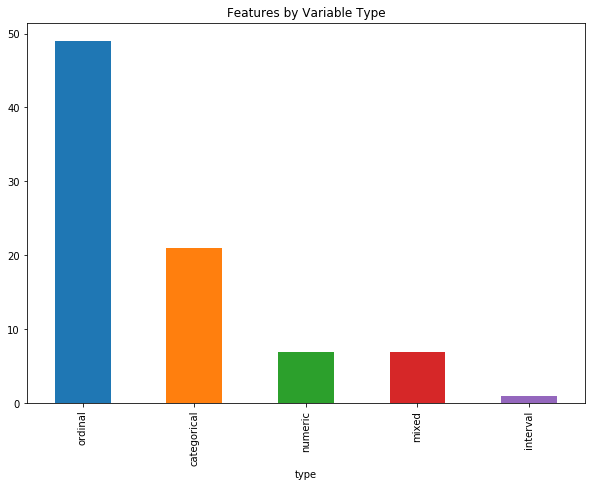

In [3]:
#attributes of the dataset
nrows, ncols = azdias.shape
azdias.head()
azdias.info()
print('rows',len(azdias))
print('columns',len(azdias.columns))

(feat_info.groupby('type').count()['attribute']
                        .sort_values(ascending = False).plot(kind = 'bar', figsize = (10, 7)))
plt.title('Features by Variable Type')
plt.show()


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. We will convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [4]:
# Converting Missing values to NaN.
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We will use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project we should just remove them from the dataframe. 


In [5]:
#calcuating missing data
missing_col = azdias.isnull().sum()
print(missing_col)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

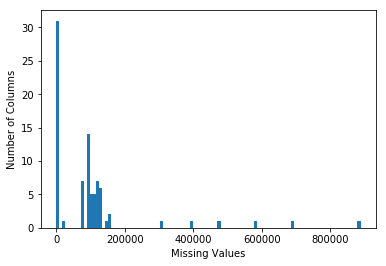

In [6]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_col, bins=100,alpha=1)
plt.ylabel('Number of Columns')
plt.xlabel('Missing Values')
plt.title('Histogram representing the count of missing values in columns')
plt.show()


In [7]:
#removing outliers
missing_col_filtered = missing_col[missing_col>200000]
azdias.drop(missing_col_filtered.index, axis=1, inplace=True)
missing_col

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [10]:
# Identify and Store the names of the columns containing more than 22% of missing values in variable 'missing_col_filtered'
print(missing_col_filtered)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


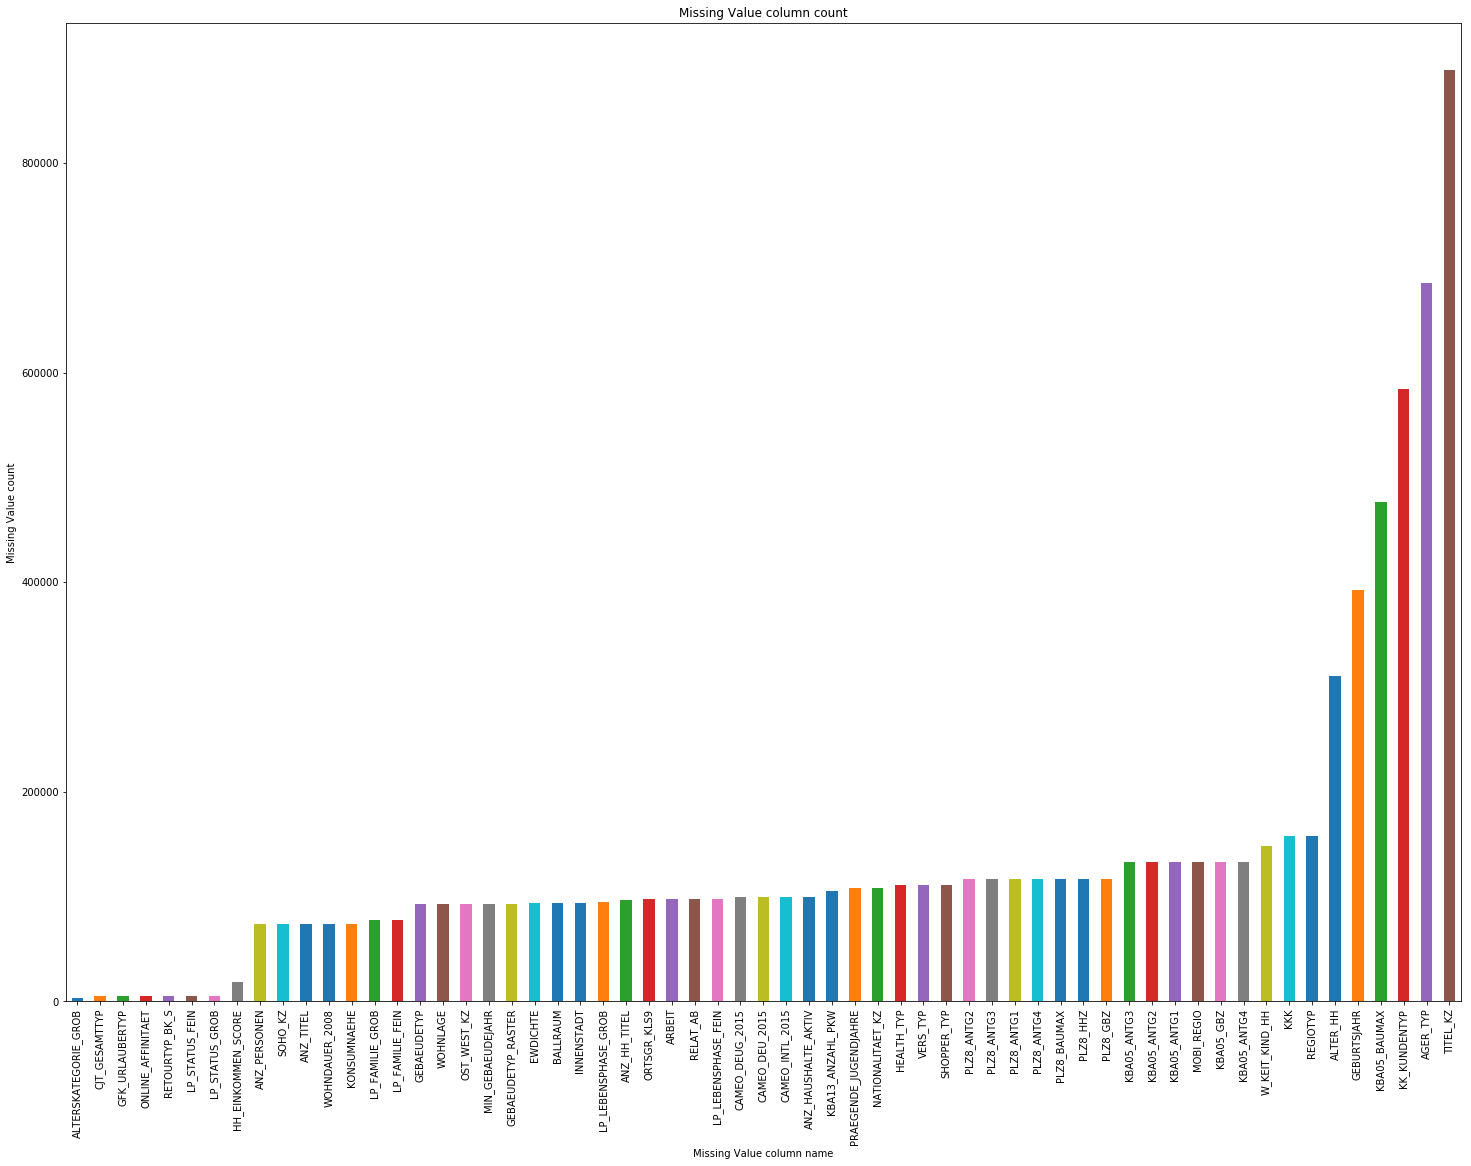

There are 61 columns with missing entries.


In [8]:
#Calculating missing columns
missing_columns = missing_col[missing_col>0]
missing_columns.sort_values(inplace=True)
missing_columns.plot.bar(figsize=(25,18))
plt.xlabel('Missing Value column name')
plt.ylabel('Missing Value count')
plt.title('Missing Value column count')
plt.show()
print("There are {} columns with missing entries.".format(len(missing_columns)))

In [ ]:
# Assessing those columns that have more than 0 missing values only
plt.hist(((missing_col[missing_col >= 1]/(azdias.shape[0])) * 100), bins=15, facecolor='y', alpha=1)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Figure 3: Histogram representing the count of missing values in percent as per columns')
plt.grid(True)

In [ ]:
# Assessing those columns that have more than 0 missing values only
plt.hist(((missing_col[missing_col >= 1]/(azdias.shape[0])) * 100), bins=15, facecolor='r', alpha=1)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Figure 3: Histogram representing the count of missing values in percent as per columns')
plt.grid(True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Are there any patterns in missing values? Which columns were removed from the dataset?

After analysing the raw dataset, it turns out that most of the columns have missing data in it. The first figure shows that multiple columns have atleast 100,000 missing values and this goes upto atleast 800,000.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- We can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, we might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. 

In [8]:
# Number of rows with missing data points
print(sum(azdias.isnull().any(axis=1)))

268012


In [9]:
#divide the dataset into 2 columns based on the number of missing entries. 
n_missing = azdias.isnull().transpose().sum()
azdias_missing_low = azdias[n_missing<20]
azdias_missing_high = azdias[n_missing>=20];
n_missing_low = azdias_missing_low.isnull().transpose().sum()
n_missing_high = azdias_missing_high.isnull().transpose().sum()

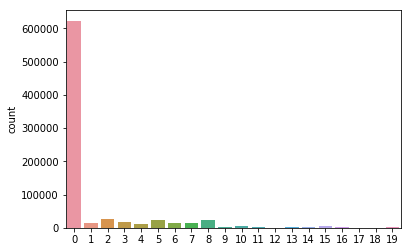

In [10]:
sns.set(style="darkgrid")
sns.countplot(azdias_missing_low.isnull().transpose().sum())

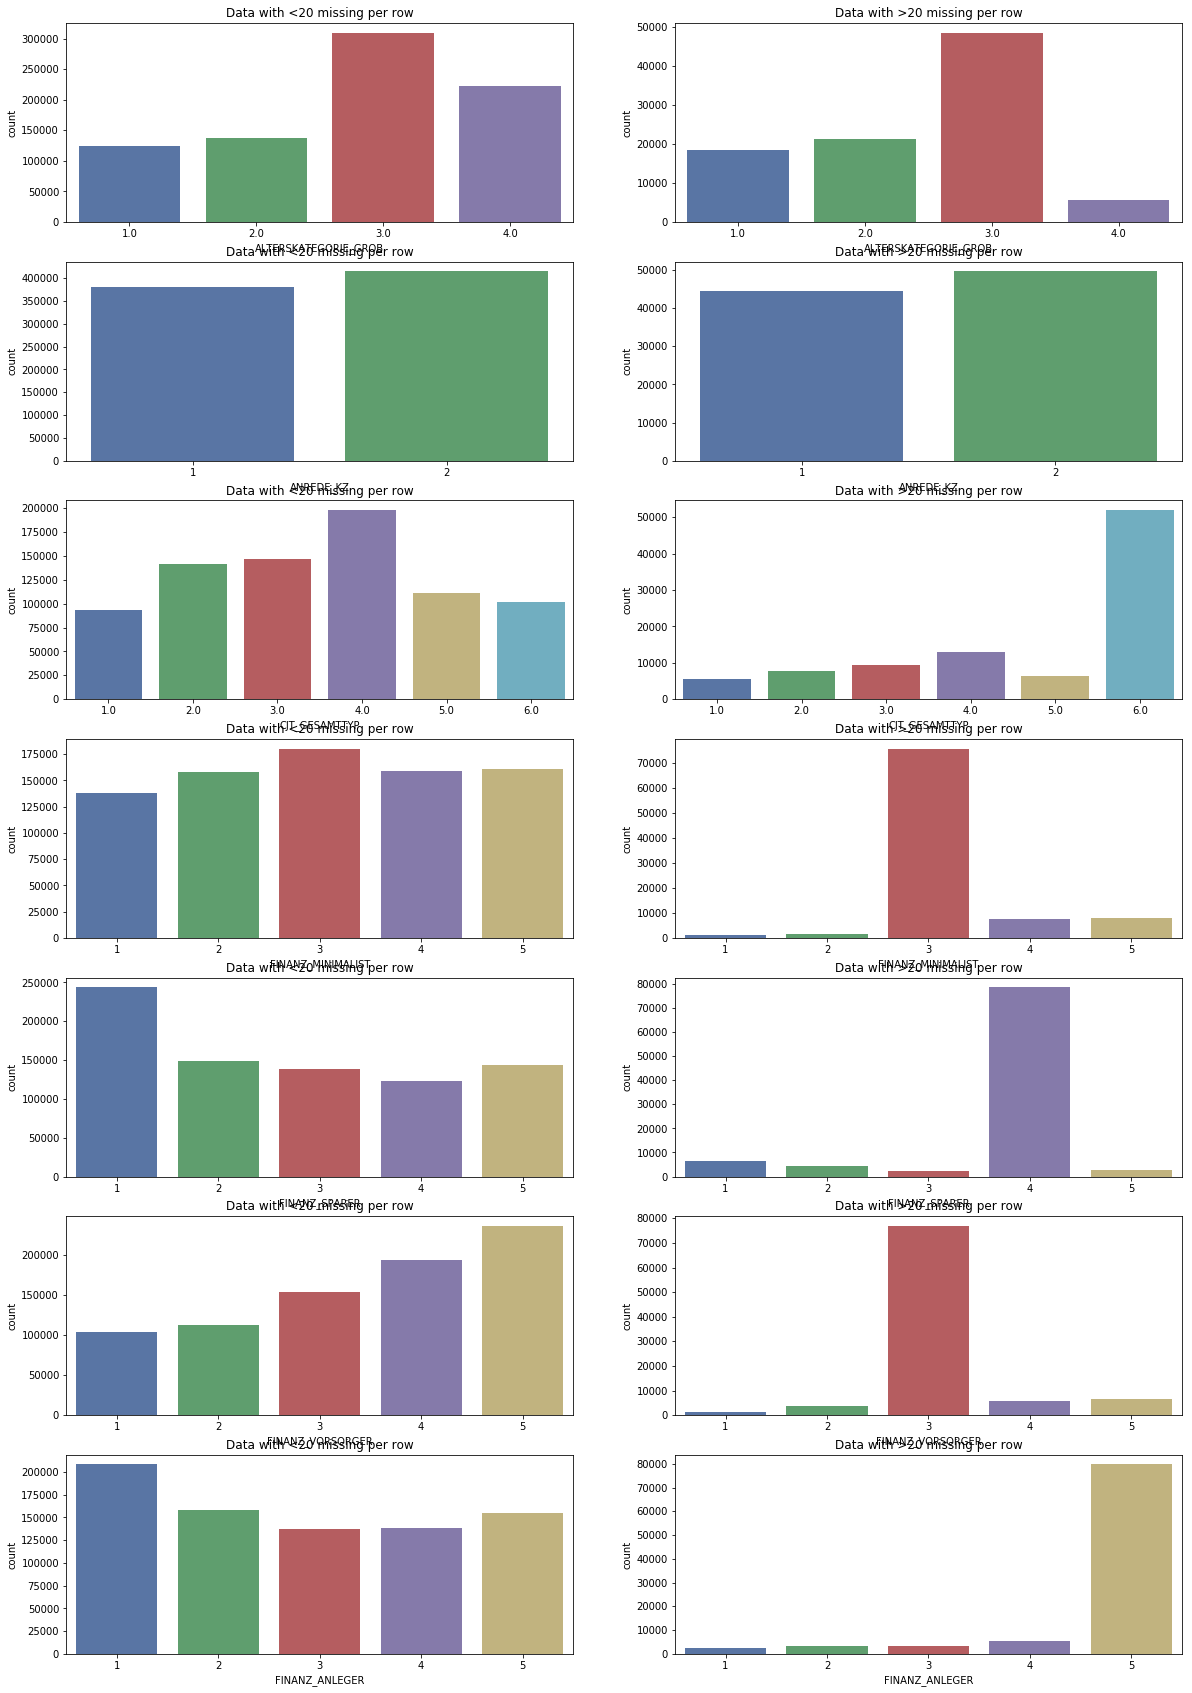

In [11]:
#Comparing the distributions between 5 columns of each dataset where one has few entires missing and the other has more than 20.
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,30))
n=0
sns.set(style="darkgrid")
for column in azdias.columns[0:7]:
    sns.countplot(azdias_missing_low.loc[:, column], ax=axes[n,0])
    axes[n,0].set_title('Data with <20 missing per row')
    sns.countplot(azdias_missing_high.loc[:, column], ax=axes[n,1])
    axes[n,1].set_title('Data with >20 missing per row')
    n+=1

#### Discussion 1.1.3: Assess Missing Data in Each Row

Are the data with lots of missing values are qualitatively different from data with few or no missing values?

From the above graph it is seen that approximately 30% of the data contains entries that have atleast one misssing value. On the other hand, approxiamtely 96429 entries from 891221, around 10%, have more than 25% data missing. From the above graph, it is seen that entries with multiple missing data have similiar distiributions to each other but these are different when we compare it with entries that have few missing values. This shows that the data is indeed qualitatively different.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. 

In [12]:
# analysing categorical data and their count of feature type 
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, we will document our choices in the Discussion section.

In [13]:
#analysing the categorical variables
categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical = [x for x in categorical if x in azdias.columns] 
binary = [x for x in categorical if azdias[x].nunique()==2]
multilevel = [x for x in categorical if azdias[x].nunique()>2]
azdias[categorical].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [14]:
azdias[categorical].nunique().sum()

138

In [15]:
#Dropping CANE_DEU_2015 since it has too many features for one column
multilevel.remove('CAMEO_DEU_2015')
azdias_missing_low.drop('CAMEO_DEU_2015', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
# converting non-numeric values with binary values
azdias_missing_low['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'O':0,'W':1})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
print(multilevel)

#converting dummy variables
for col in multilevel:
    dat = azdias_missing_low[col][azdias_missing_low[col].notnull()]
    dummies = pd.get_dummies(dat, prefix=col)
    azdias_missing_low = azdias_missing_low.join(dummies)
    azdias_missing_low.drop([col], axis=1, inplace=True)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [18]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Discussion 1.2.1: Re-Encode Categorical Features
Which ones did you keep, which did you drop, and what engineering steps did you perform?

'CAMEO_DEU_2015'has 44 features, creating a dummy variable for this column will not be efficient for calculations and this will be removed. Moreover,the data in'OST_WEST_KZ' will be converted to 0 and 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [19]:
# creating two new variables from "PRAEGENDE_JUGENDJAHRE".
mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed = [x for x in mixed if x in azdias_missing_low.columns] 

# removing variable MAINSTREAM from PRAEGENDE_JUGENDJAHRE
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
def mstream(x):
    if x in mainstream:
        return 1
    elif x in avantgarde:
        return 0
    else:
        return x

azdias_missing_low['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = azdias_missing_low['PRAEGENDE_JUGENDJAHRE'].apply(mstream)

# creating a new binary feature variable and mapping it to PRAEGENDE_JUGENDJAHRE.
x = [x+1 for x in range(15)]
y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
decade = pd.Series(y, index = x)
azdias_missing_low['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_missing_low['PRAEGENDE_JUGENDJAHRE'].map(decade)

In [20]:
# Creating new variables from "CAMEO_INTL_2015".
azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = azdias_missing_low.loc[azdias_missing_low['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

# Removing all mixed variables
azdias_missing_low.drop(mixed, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Which features did you keep, which did you drop, and what engineering steps did you perform?

Since PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 have mixed feature set, I split this into two seperate columns. Moreover, considering how LP_LEBENSPHASE_FINE and LP_LEBENSPHASE_GROB have similiar entries, LP_LEBENSPHASE_FINE was deleted because of it had 40 features and working on this would be inefficient for the dataset we have. One hot encoding was applied to LP_LEBENSPHASE_FINE.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that we have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, we should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features we created should be retained. As a reminder, the data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [21]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
            
    # removing columns and rows
    df.drop(missing_col_filtered.index , axis=1, inplace=True)
        # removing rows > 20 missing values
    n_missing = df.isnull().transpose().sum()
    df_lowmiss = df[n_missing<20]
    
    # selecting, re-encoding, and engineering column values.
    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical = [x for x in categorical if x in df_lowmiss.columns] # only the ones that are kept in dataset
    binary = [x for x in categorical if df_lowmiss[x].nunique()==2]
    multilevel = [x for x in categorical if df_lowmiss[x].nunique()>2]
    
    multilevel.remove('CAMEO_DEU_2015')
    df_lowmiss.drop('CAMEO_DEU_2015', axis=1, inplace=True) # Drop CAMEO_DEU_2015 due to too much detail
    
    df_lowmiss.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True); # Convert OST_WEST_KZ into binary categorical data
    
         #one-hot encode 
    for col in multilevel:
        dat = df_lowmiss[col][df_lowmiss[col].notnull()]
        dummies = pd.get_dummies(dat, prefix=col)
        df_lowmiss = df_lowmiss.join(dummies)
        df_lowmiss.drop([col], axis=1, inplace=True)
    
        # Extracting variable MAINSTREAM from PRAEGENDE_JUGENDJAHRE
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    df_lowmiss['PRAEGENDE_JUGENDJAHRE_MAINSTREAM'] = df_lowmiss['PRAEGENDE_JUGENDJAHRE'].apply(mstream)

        # Create variable feature 'decade' and mapping it to PRAEGENDE_JUGENDJAHRE
    x = [x+1 for x in range(15)]
    y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    decade = pd.Series(y, index = x)
    df_lowmiss['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_lowmiss['PRAEGENDE_JUGENDJAHRE'].map(decade)
    
        # Creating two new variables from "CAMEO_INTL_2015".
    df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
    df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = df_lowmiss.loc[df_lowmiss['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

        # Remove all mixed columns and LP_LEBENSPHASE_FINE  
   
        # Drop mixed columns
    mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed = [x for x in mixed if x in df_lowmiss.columns] # only the ones that are kept in df_lowmiss dataset
    df_lowmiss.drop(mixed, axis=1, inplace=True) # drop mixed features for complexity reduction
        
    # Add columns with 0 for missing data
    columns = [col for col in azdias_missing_low if col not in df_lowmiss]
    for column in columns:
        df_lowmiss[column] = 0
        
    # Return the cleaned dataframe.
    return df_lowmiss

In [22]:
print(azdias_missing_low.shape)

(797077, 148)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help us navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. We might also try a more complicated procedure where we temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data we have and what possible effects each approach might have on the analysis, and justify the decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [23]:
#Using Imputer to replace NaNs(missing values) with the mean
imputer = Imputer()
azdias_missing_low = pd.DataFrame(imputer.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_missing_low = pd.DataFrame(scaler.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

### Discussion 2.1: Apply Feature Scaling

Report your decisions regarding feature scaling.

I used imputer to replace the missing value with the mean of the column and to reducec dimensionality of the data, I used StandardScaler. 

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what we find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, we will make sure to re-fit a PCA instance to perform the decided-on transformation.

In [25]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_missing_low)

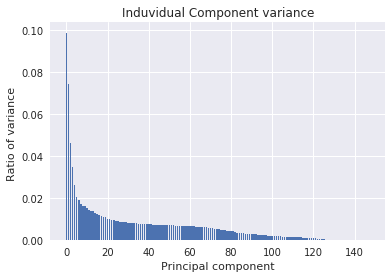

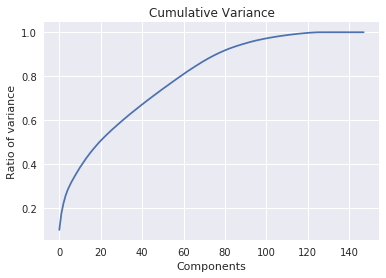

In [26]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Induvidual Component variance")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance ")
plt.show()

#cumulative variance 

plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance")
plt.xlabel("Components")
plt.ylabel("Ratio of variance")
plt.show()


In [27]:
# Re-apply PCA to the data.
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.6)[0]+1)
pca = PCA(n_components=n_components, random_state=10)
azdias_pca = pca.fit_transform(azdias_missing_low)
pca.explained_variance_ratio_.sum()

0.59715545532892866

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features  we are retaining for the next step of the analysis?

From the above graph it turns out we need 60 components to achieve 0.8 ratio of variance and approximately 30 to acheive 0.6 variance.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. We will use the data dictionary document to help us understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we will interpret the tendencies of the discovered clusters.

In [28]:
# Map weights for the first principal component to corresponding feature names sorted by weight.
def comp_analysis(azdias_missing_low):
    feature_map = pd.Series(azdias_missing_low.columns, range(len(azdias_missing_low.columns)))
    components = {}
    for ix in range(pca.components_.shape[0]):
        components[ix] = [(feature_map[a],b) for a,b in sorted(enumerate(pca.components_[ix]),key=lambda x:x[1],reverse=True)]
    return pd.DataFrame(components)

In [29]:
# Map weights for the second principal component to corresponding feature names sorted by weight.
components = comp_analysis(azdias_missing_low)
components[:10]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,"(LP_STATUS_GROB_1.0, 0.200653816488)","(ALTERSKATEGORIE_GROB, 0.229946751591)","(SEMIO_VERT, 0.319841809978)","(GREEN_AVANTGARDE, 0.293028659787)","(ANZ_PERSONEN, 0.283623277172)","(LP_STATUS_GROB_2.0, 0.327165159814)","(LP_STATUS_GROB_3.0, 0.374682885599)","(LP_FAMILIE_FEIN_2.0, 0.291540469994)","(LP_FAMILIE_FEIN_2.0, 0.466991521805)","(LP_STATUS_GROB_2.0, 0.335707928397)",...,"(MIN_GEBAEUDEJAHR, 0.250772466692)","(GEBAEUDETYP_8.0, 0.355171950588)","(LP_STATUS_FEIN_8.0, 0.344210563316)","(GEBAEUDETYP_8.0, 0.333289876973)","(ZABEOTYP_4, 0.248060068775)","(CJT_GESAMTTYP_5.0, 0.399364790442)","(CJT_GESAMTTYP_3.0, 0.200971756561)","(CJT_GESAMTTYP_5.0, 0.289540890862)","(LP_FAMILIE_FEIN_11.0, 0.390878920079)","(CAMEO_DEUG_2015_6, 0.351360116239)"
1,"(HH_EINKOMMEN_SCORE, 0.188306944637)","(FINANZ_VORSORGER, 0.215654364481)","(SEMIO_FAM, 0.26173016744)","(LP_STATUS_FEIN_10.0, 0.246672396863)","(LP_FAMILIE_GROB_5.0, 0.25665983432)","(LP_STATUS_FEIN_4.0, 0.251511771613)","(GEBAEUDETYP_3.0, 0.336448481261)","(LP_FAMILIE_GROB_2.0, 0.291540469994)","(LP_FAMILIE_GROB_2.0, 0.466991521805)","(LP_STATUS_FEIN_3.0, 0.238916754557)",...,"(SHOPPER_TYP_2.0, 0.193123533044)","(SHOPPER_TYP_3.0, 0.266736317346)","(GEBAEUDETYP_8.0, 0.282333893092)","(MIN_GEBAEUDEJAHR, 0.21674473234)","(LP_FAMILIE_FEIN_11.0, 0.226633559843)","(GEBAEUDETYP_8.0, 0.251027784356)","(CAMEO_DEUG_2015_8, 0.195386936459)","(CAMEO_DEUG_2015_3, 0.232455449865)","(SHOPPER_TYP_2.0, 0.256345650942)","(LP_FAMILIE_FEIN_11.0, 0.313188253303)"
2,"(PLZ8_ANTG3, 0.183538524743)","(ZABEOTYP_3, 0.200786268345)","(SEMIO_SOZ, 0.257699950696)","(LP_STATUS_GROB_5.0, 0.246672396863)","(LP_FAMILIE_FEIN_10.0, 0.196813454436)","(FINANZ_HAUSBAUER, 0.216798180282)","(LP_STATUS_FEIN_6.0, 0.332403541231)","(LP_FAMILIE_GROB_4.0, 0.271716799185)","(W_KEIT_KIND_HH, 0.171059748332)","(ARBEIT, 0.180205770175)",...,"(GEBAEUDETYP_1.0, 0.189736518295)","(SHOPPER_TYP_2.0, 0.203350431566)","(GFK_URLAUBERTYP_12.0, 0.218745658068)","(SHOPPER_TYP_0.0, 0.213189098127)","(CAMEO_DEUG_2015_2, 0.211610280765)","(RELAT_AB, 0.176858537732)","(FINANZTYP_2, 0.175399755842)","(GFK_URLAUBERTYP_10.0, 0.185256175741)","(CJT_GESAMTTYP_5.0, 0.194114555334)","(LP_FAMILIE_FEIN_5.0, 0.259757407417)"
3,"(CAMEO_INTL_2015_WEALTH, 0.182614342525)","(SEMIO_ERL, 0.179893202787)","(SEMIO_KULT, 0.252421088948)","(EWDICHTE, 0.212783456159)","(KKK, 0.190285361617)","(LP_FAMILIE_GROB_5.0, 0.197468080334)","(LP_STATUS_FEIN_7.0, 0.166611028866)","(LP_FAMILIE_FEIN_7.0, 0.189373931645)","(LP_STATUS_GROB_3.0, 0.122979337686)","(LP_STATUS_FEIN_4.0, 0.18009229166)",...,"(LP_STATUS_FEIN_8.0, 0.184410084142)","(FINANZTYP_4, 0.203269431381)","(CJT_GESAMTTYP_3.0, 0.216364016474)","(FINANZTYP_3, 0.207664436747)","(CAMEO_DEUG_2015_7, 0.210432832943)","(CAMEO_DEUG_2015_4, 0.145646664789)","(GFK_URLAUBERTYP_3.0, 0.171401991361)","(LP_FAMILIE_FEIN_9.0, 0.160688985414)","(GFK_URLAUBERTYP_11.0, 0.165912272255)","(CJT_GESAMTTYP_1.0, 0.165254629417)"
4,"(PLZ8_ANTG4, 0.177871587872)","(SEMIO_LUST, 0.161973734959)","(FINANZTYP_5, 0.134922827417)","(ORTSGR_KLS9, 0.209438410566)","(PRAEGENDE_JUGENDJAHRE_MAINSTREAM, 0.169008133...","(LP_STATUS_GROB_3.0, 0.190917777415)","(ANZ_HH_TITEL, 0.139915129551)","(LP_FAMILIE_GROB_3.0, 0.187565338308)","(LP_STATUS_FEIN_2.0, 0.105913206652)","(FINANZTYP_6, 0.162797089266)",...,"(GFK_URLAUBERTYP_12.0, 0.179110142671)","(LP_STATUS_FEIN_5.0, 0.157240049337)","(CAMEO_DEUG_2015_3, 0.188754225273)","(CJT_GESAMTTYP_3.0, 0.200633463089)","(SHOPPER_TYP_3.0, 0.177501550474)","(ARBEIT, 0.134423227937)","(GEBAEUDETYP_6.0, 0.170549882118)","(CAMEO_INTL_2015_LIFESTAGE, 0.159967959562)","(CAMEO_DEUG_2015_7, 0.150742076747)","(GFK_URLAUBERTYP_8.0, 0.159581417109)"
5,"(ORTSGR_KLS9, 0.156731814711)","(RETOURTYP_BK_S, 0.155949606877)","(FINANZ_MINIMALIST, 0.127620868025)","(ANZ_PERSONEN, 0.165410309278)","(LP_STATUS_FEIN_9.0, 0.154567371819)","(LP_STATUS_FEIN_6.0, 0.165439851311)","(ANZ_TIT

In [30]:
# Top 10 negative components
components[-10:]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
138,"(LP_STATUS_FEIN_10.0, -0.118088276288)","(SEMIO_KULT, -0.164240046409)","(LP_STATUS_FEIN_2.0, -0.0789957549098)","(LP_STATUS_FEIN_4.0, -0.139718348333)","(FINANZ_UNAUFFAELLIGER, -0.104351430679)","(LP_STATUS_FEIN_8.0, -0.123067525959)","(KBA05_ANTG2, -0.111993135721)","(ZABEOTYP_5, -0.0917871987248)","(LP_FAMILIE_FEIN_11.0, -0.0971711943523)","(LP_STATUS_FEIN_1.0, -0.116776933019)",...,"(SEMIO_LUST, -0.102495880633)","(FINANZTYP_2, -0.102660222452)","(CAMEO_DEUG_2015_5, -0.0951696379237)","(GFK_URLAUBERTYP_8.0, -0.106015867805)","(GFK_URLAUBERTYP_7.0, -0.134988658273)","(CAMEO_DEUG_2015_6, -0.112500896184)","(LP_FAMILIE_FEIN_9.0, -0.111883992627)","(GEBAEUDETYP_2.0, -0.113639489337)","(CJT_GESAMTTYP_1.0, -0.12738541638)","(SHOPPER_TYP_2.0, -0.11449530464)"
139,"(LP_STATUS_GROB_5.0, -0.118088276288)","(SEMIO_RAT, -0.164677702225)","(SHOPPER_TYP_2.0, -0.0989361952262)","(KKK, -0.146247533414)","(LP_STATUS_FEIN_10.0, -0.111928361942)","(ORTSGR_KLS9, -0.123260066843)","(KBA05_ANTG3, -0.117371696494)","(W_KEIT_KIND_HH, -0.099212906357)","(LP_STATUS_FEIN_1.0, -0.0976878281294)","(LP_STATUS_FEIN_2.0, -0.121758921102)",...,"(LP_FAMILIE_FEIN_7.0, -0.108169042673)","(CAMEO_INTL_2015_LIFESTAGE, -0.105971780292)","(GEBAEUDETYP_2.0, -0.0962536907965)","(ANZ_HAUSHALTE_AKTIV, -0.107644569419)","(LP_FAMILIE_FEIN_10.0, -0.137451782786)","(CAMEO_DEUG_2015_5, -0.119772410056)","(GFK_URLAUBERTYP_4.0, -0.117539234151)","(LP_FAMILIE_FEIN_10.0, -0.121885825817)","(GFK_URLAUBERTYP_1.0, -0.127571669766)","(CAMEO_DEUG_2015_3, -0.123859119419)"
140,"(INNENSTADT, -0.12922464858)","(ONLINE_AFFINITAET, -0.16643310316)","(FINANZTYP_1, -0.100470584761)","(HH_EINKOMMEN_SCORE, -0.153108855682)","(LP_STATUS_GROB_5.0, -0.111928361942)","(FINANZ_MINIMALIST, -0.138052358748)","(LP_STATUS_GROB_2.0, -0.119138817274)","(LP_STATUS_FEIN_2.0, -0.100547737962)","(LP_FAMILIE_FEIN_7.0, -0.110454555365)","(FINANZTYP_1, -0.125514311032)",...,"(LP_FAMILIE_GROB_4.0, -0.111898106575)","(LP_FAMILIE_FEIN_10.0, -0.109804678307)","(GFK_URLAUBERTYP_2.0, -0.100238146474)","(SEMIO_LUST, -0.138742833924)","(LP_FAMILIE_FEIN_8.0, -0.141684735446)","(GFK_URLAUBERTYP_1.0, -0.12122320934)","(LP_STATUS_FEIN_2.0, -0.137510181748)","(GFK_URLAUBERTYP_2.0, -0.125568917222)","(FINANZTYP_6, -0.1476817859)","(GFK_URLAUBERTYP_12.0, -0.140462398374)"
141,"(PLZ8_GBZ, -0.134264251302)","(FINANZ_ANLEGER, -0.200322950814)","(FINANZ_ANLEGER, -0.15349857012)","(INNENSTADT, -0.17297010931)","(LP_STATUS_FEIN_3.0, -0.113982239821)","(MIN_GEBAEUDEJAHR, -0.139283356315)","(LP_FAMILIE_FEIN_2.0, -0.119192082462)","(LP_STATUS_FEIN_10.0, -0.107174700534)","(LP_FAMILIE_FEIN_10.0, -0.118461287777)","(LP_FAMILIE_FEIN_2.0, -0.173933136313)",...,"(LP_STATUS_FEIN_1.0, -0.115360257139)","(LP_STATUS_FEIN_3.0, -0.114909103456)","(LP_STATUS_FEIN_9.0, -0.132201854495)","(ANZ_HH_TITEL, -0.148178437096)","(GEBAEUDETYP_2.0, -0.146302228538)","(ZABEOTYP_4, -0.128013437654)","(SEMIO_LUST, -0.138564971791)","(LP_STATUS_FEIN_5.0, -0.136964483238)","(GFK_URLAUBERTYP_10.0, -0.172807310594)","(CJT_GESAMTTYP_5.0, -0.150109510257)"
142,"(KONSUMNAEHE, -0.13762174833)","(SEMIO_PFLICHT, -0.20107824649)","(SEMIO_RAT, -0.156805019988)","(BALLRAUM, -0.17386298839)","(PLZ8_GBZ, -0.125416526579)","(LP_STATUS_FEIN_10.0, -0.150519399868)","(LP_FAMILIE_GROB_2.0, -0.119192082462)","(LP_STATUS_GROB_5.0, -0.107174700534)","(LP_FAMILIE_GROB_5.0, -0.163686132025)","(LP_FAMILIE_GROB_2.0, -0.173933136313)",...,"(CJT_GESAMTTYP_2.0, -0.128962924327)","(GEBAEUDETYP_3.0, -0.140056477022)","(GFK_URLAUBERTYP_3.0, -0.13870621064)","(LP_STATUS_FEIN_8.0, -0.161394798561)","(RELAT_AB, -0.153507255155)","(GFK_URLAUBERTYP_11.0, -0.12877305843)","(LP_FAMILIE_FEIN_8.0, -0.143569434973)","(FINANZTYP_5, -0.13782071895)","(SHOPPER_TYP_3.0, -0.173123120083)","(LP_FAMILIE_FEIN_7.0, -0.159012148335)"
143,"(PLZ8_ANTG1, -0.183868195448)","(SEMIO_TRADV, -0.206265437972)","(SEMIO_ERL, -0.207534690665)","(LP_FAMILIE_FEIN

In [31]:
def comp(components,compnum):
    print('Top positive components {}\n\n'.format(compnum), components.loc[:8,compnum])
    print('Top negative components {}\n\n'.format(compnum), components.loc[components.shape[0]-8:,compnum].head(8))

# Mapping weights for the third principal component to corresponding feature names sorted by weight.
components.loc[:,:].head(8)
# 3rd Component
for num in range(3):
    comp(components,num)

Top positive components 0

 0        (LP_STATUS_GROB_1.0, 0.200653816488)
1        (HH_EINKOMMEN_SCORE, 0.188306944637)
2                (PLZ8_ANTG3, 0.183538524743)
3    (CAMEO_INTL_2015_WEALTH, 0.182614342525)
4                (PLZ8_ANTG4, 0.177871587872)
5               (ORTSGR_KLS9, 0.156731814711)
6                  (EWDICHTE, 0.155320724627)
7          (FINANZ_HAUSBAUER, 0.150463657155)
8               (KBA05_ANTG4, 0.128776039827)
Name: 0, dtype: object
Top negative components 0

 140            (INNENSTADT, -0.12922464858)
141             (PLZ8_GBZ, -0.134264251302)
142           (KONSUMNAEHE, -0.13762174833)
143           (PLZ8_ANTG1, -0.183868195448)
144            (KBA05_GBZ, -0.184239136675)
145          (KBA05_ANTG1, -0.194148542724)
146    (FINANZ_MINIMALIST, -0.200340836694)
147           (MOBI_REGIO, -0.207184670823)
Name: 0, dtype: object
Top positive components 1

 0    (ALTERSKATEGORIE_GROB, 0.229946751591)
1        (FINANZ_VORSORGER, 0.215654364481)
2              (

### Discussion 2.3: Interpret Principal Components

Can we interpret positive and negative values from them in a meaningful way?)

* **Component 0: Urban population of low socio-economic status**
This group of people can be best described as people from low socio-economic means.I can say this because from the above component it was seen that this group has low income, compared to the other component. One interesting feature that was observed which is characteristic to this group is that they have relatively low levels of house-ownership compared to the other groups. 

<br>    
* **Component 1: Senior citizens with middle class economic status**
This group of people, like the above group, also reside in the low socio-economic part of the society. However, this component of the society was found to have higher mean age than the other components and had higher level of net worth.

<br>
* **Component 2: Single Males**
Finally, the last group of people seem to be induviduals who are not leaning towards the traditional definition of a family. This set of people seems to be young, financially spend thrift and mostly seems to comprise of males. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

So far We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help our understanding.
- Perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. We should test for cluster counts through at least 10 clusters to get the full picture, but we shouldn't need to test for a number of clusters above about 30.
- Once we've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that We also obtain the cluster assignments for the general demographics data, since we'll be using them in the final Step 3.3.

In [32]:
azdias_missing_low.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9',
       'PRAEGENDE_JUGENDJAHRE_MAINSTREAM', 'PRAEGENDE_JUGENDJAHRE_DECADE',
       'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE'],
      dtype='object', length=148)

In [33]:
from sklearn.cluster import KMeans, MiniBatchKMeans
#Over a number of different cluster counts...
kmeans_scores = []
for i in range(2,50,1):

    #run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(azdias_pca)
    
    #compute the average within-cluster distances.
    print(i,kmeans.score(azdias_pca))
    kmeans_scores.append(kmeans.score(azdias_pca))

2 -61910213.9231
3 -59101249.9958
4 -54267379.219
5 -52892380.0108
6 -50809361.6799
7 -51040917.6436
8 -48191490.6989
9 -48557083.8684
10 -46729042.698
11 -46787228.3431
12 -45820511.5105
13 -44207610.0619
14 -45547293.0965
15 -43777075.9437
16 -44268449.6743
17 -43452204.4813
18 -42276471.841
19 -42681001.4528
20 -41081561.4428
21 -40412290.5137
22 -39419406.8205
23 -41812006.043
24 -39148555.0358
25 -38989629.4906
26 -38529282.7031
27 -38233429.5358
28 -38144030.0921
29 -38165380.146
30 -39164332.0064
31 -37679886.3503
32 -37292900.0595
33 -36830052.3891
34 -36645620.2386
35 -37130165.1587
36 -36249935.2516
37 -35873202.6788
38 -35556042.7025
39 -35793530.857
40 -37879504.7389
41 -35777275.9328
42 -35150301.2664
43 -34977829.5956
44 -34844520.8677
45 -34680527.5877
46 -34688047.0174
47 -36235979.7354
48 -34268580.0827
49 -34026610.8465


In [35]:
# Re-fit the k-means model with the selected number of clusters 
kmeans = KMeans(20, random_state=10)
clusters_pop = kmeans.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Into how many clusters have we decided to segment the population?)

To test kmeans with n_components ranging from 2 upto to 50 is a very time consuming task thus opting for MiniBatchKmeans helps to improve performance. We have seen that the marginal drop in distance is diminishing or depicts closer difference in distances at around 20 clusters so we decided to move forward with 20 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We will take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- We will use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [36]:
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
cust.shape

(191652, 85)

In [37]:
#preprocessing the data and applying feature transformations and other data transformation techniques as we did in "azdias"
cust = clean_data(cust)
cust = pd.DataFrame(imputer.transform(cust), columns = cust.columns)

# Standardize 
cust = pd.DataFrame(scaler.transform(cust), columns = cust.columns)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [39]:
cust_pca = pca.transform(cust)
clusters_cust = kmeans.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis we performed in step 1.1.3 of the project, where we separated out certain data points from the dataset if they had more than a specified threshold of missing values. If we found that this group was qualitatively different from the main bulk of the data, we should treat this as an additional data cluster in this analysis. Make sure that we account for the number of data points in this subset, for both the general population and customer datasets, when making our computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help we make this inference. Alternatively, we can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

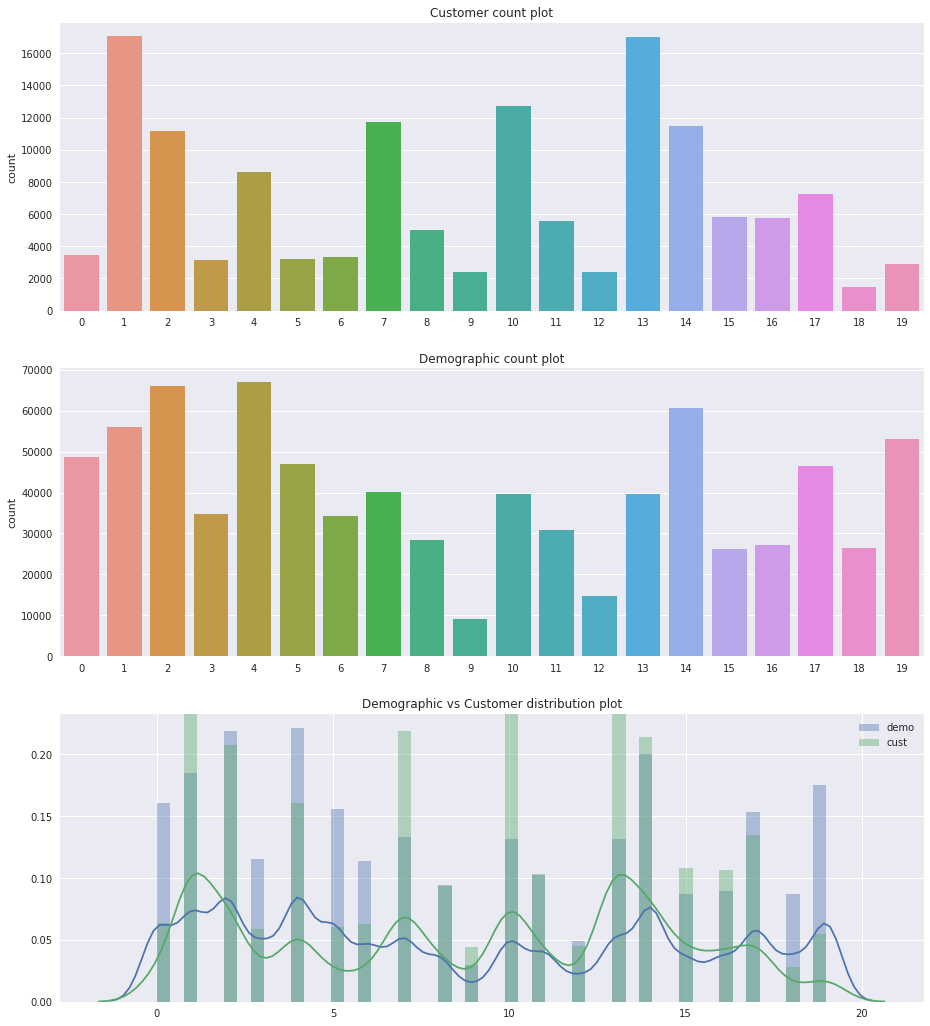

In [40]:
fig = plt.figure()
ax=fig.add_axes([0,0,2,1], title='Demographic vs Customer distribution plot')
ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
sns.set(style="darkgrid")
sns.distplot(clusters_pop, label='demo',ax=ax)
sns.distplot(clusters_cust, label='cust', ax=ax)
sns.countplot(clusters_pop, label='demo', ax=ax2)
sns.countplot(clusters_cust, label='cust', ax=ax3)
ax.legend();

In [41]:
# Comparing the proportion of data in each cluster for the customer data to the general population.
cust_df = pd.DataFrame(clusters_cust,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(clusters_cust)*100
pop_df = pd.DataFrame(clusters_pop,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(clusters_pop)*100
diff = (cust_df-pop_df)
diff.rename_axis({'index':'DiffPerc'}, axis=1, inplace=True)
cust_df.rename_axis({'index':'CustPerc'}, axis=1, inplace=True)
pop_df.rename_axis({'index':'PopPerc'}, axis=1, inplace=True)
diff = diff.join(cust_df).join(pop_df).sort_values('DiffPerc',ascending=False)
diff.fillna(0, inplace=True)
diff

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  import sys


,DiffPerc,CustPerc,PopPerc
Cluster,,,
13,7.045221,12.035454,4.990233
1,5.026103,12.046755,7.020652
10,3.996003,8.977329,4.981326
7,3.255139,8.304965,5.049826
15,0.807243,4.101278,3.294036
16,0.654394,4.050427,3.396033
9,0.532162,1.675966,1.143804
14,0.500232,8.110036,7.609804
11,0.036408,3.920475,3.884066


In [42]:
#finding out the overrepresented people in the customer segment.
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=azdias_missing_low.columns)
cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MAINSTREAM,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,2.743810,1.763310,2.788022,2.373631,3.784181,2.519870,2.564210,3.956689,0.281354,1.984788,...,-0.028058,0.113452,0.007435,0.169093,0.109435,0.923331,64.287043,3.767643,4.589735,-0.739793
1,4.083119,1.355594,5.443838,0.578327,5.304881,0.647289,1.293505,2.119566,1.427595,1.667444,...,0.115800,0.105009,0.054489,0.034042,-0.024390,0.329616,33.938620,1.307371,2.290812,0.542443
2,4.092346,1.719704,3.799703,1.000091,5.085722,1.151357,1.209742,3.791699,0.225628,1.863835,...,0.013590,0.090729,0.088892,0.084755,0.161132,0.653480,65.970432,1.639426,4.295920,-0.193088
3,2.768664,1.753173,3.406661,2.218891,3.804164,2.812036,2.933620,2.802490,0.475197,2.066251,...,0.152365,0.141597,0.053546,0.067420,0.005546,0.272229,59.386999,3.945904,2.499229,0.209217
4,3.767271,0.905629,4.297144,1.060052,5.022756,0.803417,1.177767,3.120626,0.227816,2.130456,...,-0.000695,0.054411,0.065389,0.115323,0.160383,0.741239,66.164550,1.855196,4.457177,-0.445733
5,2.768878,1.779828,2.897032,2.390756,3.871333,2.735269,2.802239,3.677307,0.272292,1.964740,...,0.060202,0.098725,0.125510,0.115408,0.063109,0.509677,64.552574,3.800292,3.693419,-0.077013
6,2.794591,0.783653,3.883265,2.314122,3.702247,2.423067,2.946205,2.434863,0.515650,2.014158,...,0.147625,0.134842,0.082325,0.037846,0.027650,0.329025,58.380754,4.023168,2.794410,0.219819
7,3.785480,1.223046,4.495206,0.835881,5.139197,0.565542,1.451278,3.375099,0.770109,1.855939,...,0.038276,0.260917,0.119417,0.178820,0.007272,0.439043,51.451103,1.669776,3.502857,0.152184
8,3.414147,1.299578,5.018829,1.508473,4.386568,1.877114,2.168925,1.022817,0.781908,2.016072,...,0.160727,0.145076,0.039455,0.040753,-0.048488,0.352253,51.548902,3.331344,2.369090,0.250642
9,3.724285,1.225167,4.802313,0.964971,4.932751,1.020187,1.565835,2.647041,0.969810,1.847687,...,0.008330,0.299659,-0.032694,0.117913,0.001004,0.413512,46.200920,1.875796,2.677478,0.405541


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with our own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Conclusion: From the last figure on comparing the ratio of clusters, 1, 3 and 9 are significantly higher in the customer data relative to the demographic/population data. These clusters  are more than 40 years old, predominantly male, have comparitavely higher levels of net income and likely to own a house.

Cluster 1:
Represents mostly males who are more than 40 years old, with low debt, traditionally family oriented, most likely to own homes and with the highest level of net worth in the area.

Cluster 3:
This cluster is similar to the cluster above. This cluster also comprises mostly of males who are more than 40 years old with low debt and traditionally family oriented. The only difference is that this cluster has lower net worth than the above cluster.

Cluster 9:
Like the above 2 clusters, this cluster also largely comprises of males who are more than 40 years old, family oriented. However, this cluster has the lowest income level out of all the three clusters and most likely to not be a homeowner. 